# **DGA Classification Task** 


**Methodology** : Get a classified DGA dataset, use it as "train data" then test it using a fresh dataset.

**Classification Approach**: Basically, I'll be using a pattern based approach. From the domain in the datasets, i'll find the characteristics of each domain such as: vowel-consonant ratio, length of domain, number of identified digits, entropy, n-grams. These characteristics are numerical and will help any classifier ML model form a pattern for classification. In essence, new input features will be generated from the domain. 

Link to reference approach: https://cyber.wtf/2017/08/30/dga-classification-and-detection-for-automated-malware-analysis/

Generally, ML models only understand numerical data. So there has to be a way of translate non-numerical data to an algorithm hence, the numerical characteristics. After a successful translation and addition of input variables, the domain column will be dropped. 

The dataset was obtained from Alexa website ranking a blacklist of previous DGA domain names.
The purpose is to build a classifier which can help us detect a potential machine infected by the DGA (Domain Generation Algorithm) malware.

Link to reference dataset: https://www.kaggle.com/datasets/gtkcyber/dga-dataset

In [ ]:
# importing needed libraries

import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn import feature_extraction, tree, model_selection, metrics
from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz
from yellowbrick.features import ParallelCoordinates
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [ ]:
## Load data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dga_classifier/dga_data.csv')

Getting general data details i.e. finding out if there are null values, the number of columns present, datatype for each column and the total number of datapoints.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   isDGA     160000 non-null  object
 1   domain    159998 non-null  object
 2   host      160000 non-null  object
 3   subclass  160000 non-null  object
dtypes: object(4)
memory usage: 4.9+ MB


In [ ]:
# finding the total of empty rows per column
df.isnull().sum()

isDGA       0
domain      2
host        0
subclass    0
dtype: int64

### Data Preprocessing of Train Data

Data preprocessing is necessary to clean and prepare the data for the machine learning algorithm. Preprocessed data maximizes the abilities of the ML model because, data is fed into it in its language (understood datatype).

In [ ]:
# dropping empty rows in the domain column
df.dropna(subset=['domain'], inplace=True)

In [ ]:
df.isnull().sum()

isDGA       0
domain      0
host        0
subclass    0
dtype: int64

In [ ]:
# dropping columns that won't be relevant to the pattern based approach
df.drop(['host', 'subclass'], axis=1, inplace=True)
print(df.shape)
df.sample(n=5).head() # print a random sample of the DataFrame

(159998, 2)


,isDGA,domain
54424,dga,ynmewoowqcwagy
72729,dga,riwlphuhhvue
28829,dga,8rknb4qgbfey14hp450djc1px
148940,legit,lapoliciaca
109994,legit,khaberni


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159998 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   isDGA   159998 non-null  object
 1   domain  159998 non-null  object
dtypes: object(2)
memory usage: 3.7+ MB


In [ ]:
# to understand the distribution of our data points
df.value_counts('isDGA')

isDGA
dga      80000
legit    79998
dtype: int64

conclusion: data samples are almost evenly distributed.

In [ ]:
# Google's 10000 most common english words will be needed to derive a feature called ngrams...
# This dataset contains a list of the 10,000 most common English words in order of frequency, as determined by n-gram frequency analysis of the Google's Trillion Word Corpus.

top_en_words = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dga_classifier/google-10000-english.txt', header=None, names=['words'])
top_en_words.sample(n=5).head()

,words
3422,bowl
2509,spa
4954,reproduction
219,travel
4904,den


To understand the purpose of this dataset better and how it will assist with the ngrams part, follow this link: https://github.com/first20hours/google-10000-english

Link to download the data: https://resources.oreilly.com/live-training/enhanced-machine-learning-for-cybersecurity/blob/master/Data/google-10000-english.txt

### **Feature Engineering** 

In this section, we will write functions that will help us translate the features of the domain into numerical data. With this, the ML Model will be able to pick up patterns easily that will help it decipher between domains created by DGA's and legitimate domains.

PS: ML Models function best with numerical and categorical data.

The following numerical features that will be derived from the domain string are:


*   Length of string
*   Number of digits

*   Entropy
*   Vowel - Consonant ratio

*   N-grams









Entropy means the degree of randomness in a word. In this case, the word is the domain. According to research, words that are very random don't make any sense in English e.g. erhkldm23 compared to 'facebook' which makes more sense.

Basically, a normal domain name usually consists of English words or their abbreviations, while a DGA domain name is often composed of clustered letters and random numbers.

Information entropy allows you to determine how much randomness is present in a string, and randomness in a URL is often an indicator of a malicious site.

Reference Link to the statements above: 
https://lantern.splunk.com/Security_Use_Case_Guidance/Security_Investigations/Incident_Response_and_Reporting/Detecting_the_use_of_randomization_in_cyberattacks/Algorithmically_generated_domain_names

https://www.atlantis-press.com/proceedings/mmsa-18/25894313

https://www.splunk.com/en_us/blog/security/random-words-on-entropy-and-dns.html?_ga=2.268093446.920741133.1649387478-223943148.1649386827&_gl=1*1tn069e*_ga*MjIzOTQzMTQ4LjE2NDkzODY4Mjc.*_gid*OTIwNzQxMTMzLjE2NDkzODc0Nzg.

To this effect a formula was developed in order to calculate entropy thus as follows: 

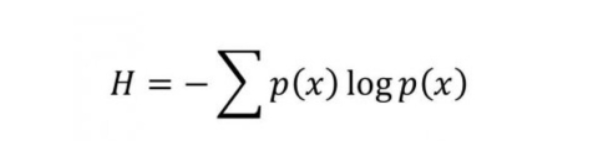

This formula is what I applied to the entropy function below.


In [ ]:
df['length'] = [len(x) for x in df['domain']] # This code will create a new column called 'length' and get the length of each domain in the dataset.

import math
from collections import Counter  # this library will be applied to the 'number of digits' code.
 
# Function to calculate the entropy of every domain in the dataset
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())
  
df['entropy'] = [entropy(x) for x in df['domain']]

# Function to calculate the vowel-consonant ratio per domain
def vowel_consonant_ratio (x):
    # Calculate vowel to consonant ratio
    x = x.lower()
    vowels_pattern = re.compile('([aeiou])')
    consonants_pattern = re.compile('([b-df-hj-np-tv-z])')
    vowels = re.findall(vowels_pattern, x)
    consonants = re.findall(consonants_pattern, x)
    try:
        ratio = len(vowels) / len(consonants)
    except: # catch zero devision exception 
        ratio = 0  
    return ratio

In [ ]:
# derive features and addition of these new features as new columns to the already existing dataset
df['length'] = df.domain.str.len()
df['digits'] = df.domain.str.count('[0-9]')  # counts the number of digits in each domain.
df['entropy'] = df.domain.apply(entropy)
df['vowel-cons'] = df.domain.apply(vowel_consonant_ratio)

# encode strings of target variable as integers (categorical values)
df.isDGA = df.isDGA.replace(to_replace = 'dga', value=1)
df.isDGA = df.isDGA.replace(to_replace = 'legit', value=0)
print(df.isDGA.value_counts())

# check intermediate 2D pandas DataFrame
df.sample(n=5).head()

1    80000
0    79998
Name: isDGA, dtype: int64


,isDGA,domain,length,entropy,digits,vowel-cons
110394,0,passeidireto,12,3.084963,0,1.000000
128737,0,igirlgames,10,2.921928,0,0.666667
128430,0,huislijn,8,2.750000,0,0.600000
4149,1,hrtomjdklwqlbbm,15,3.506891,0,0.071429
29205,1,1dwt3rwim109z1xj5mjei95bvv,26,3.979098,9,0.214286


**Purpose of the ngrams function**: every domain row is compared with google's 10000 most common English words. Thereafter, each domain's ngram will be compared to its frequency of occurrence in the list of common English words. Now based on their individual frequency of occurrence, an ngram weight/ value will be assigned to every domain.

In [ ]:
def ngrams(word, n):
    # Extract all ngrams and return a regular Python list
    # Input word: can be a simple string or a list of strings
    # Input n: Can be one integer or a list of integers 
    # if you want to extract multipe ngrams and have them all in one list
    
    l_ngrams = []
    if isinstance(word, list):
        for w in word:
            if isinstance(n, list):
                for curr_n in n:
                    ngrams = [str(w)[i:i+curr_n] for i in range(0,len(str(w))-curr_n+1)]
                    l_ngrams.extend(ngrams)
            else:
                ngrams = [w[i:i+n] for i in range(0,len(w)-n+1)]
                l_ngrams.extend(ngrams)
    else:
        if isinstance(n, list):
            for curr_n in n:
                ngrams = [word[i:i+curr_n] for i in range(0,len(word)-curr_n+1)]
                l_ngrams.extend(ngrams)
        else:
            ngrams = [word[i:i+n] for i in range(0,len(word)-n+1)]
            l_ngrams.extend(ngrams)
#     print(l_ngrams)
    return l_ngrams
def ngram_feature(domain, d, n):
    # Input is your domain string or list of domain strings
    # a dictionary object d that contains the count for most common english words
    # finally you can either have an int list or simple int defining the ngram length
    
    # Core magic: Looks up domain ngrams in english dictionary ngrams and sums up the 
    # respective english dictionary counts for the respective domain ngram
    # sum is normalized
    
    l_ngrams = ngrams(domain, n)
#     print(l_ngrams)
    count_sum=0
    for ngram in l_ngrams:
        if d[ngram]:
            count_sum+=d[ngram]
    try:
        feature = count_sum/(len(domain)-n+1)
    except:
        feature = 0
    return feature
    
def average_ngram_feature(l_ngram_feature):
    # input is a list of calls to ngram_feature(domain, d, n)
    # usually you would use various n values, like 1,2,3...
    return sum(l_ngram_feature)/len(l_ngram_feature)


l_en_ngrams = ngrams(list(top_en_words['words']), [1,2,3])
d = Counter(l_en_ngrams)

from six.moves import cPickle as pickle
with open('/content/drive/MyDrive/Colab Notebooks/dga_classifier/d_common_en_words.pickle' + '.pickle', 'wb') as f:
        pickle.dump(d, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
df['ngrams'] = df.domain.apply(lambda x: average_ngram_feature([ngram_feature(x, d, 1), 
                                                                ngram_feature(x, d, 2), 
                                                                ngram_feature(x, d, 3)]))

# check final 2D pandas DataFrame containing all final features and the target vector isDGA
df.sample(n=5).head()

,isDGA,domain,length,entropy,digits,vowel-cons,ngrams
57140,1,wgvspjhygpflbqibkzsqcsfaobae,28,4.110577,0,0.217391,812.741080
104219,0,diccionari,10,2.646439,0,1.000000,1663.307407
143607,0,trackthis,9,2.947703,0,0.285714,1420.720238
63397,1,guumvvxg,8,2.250000,0,0.333333,474.650794
39984,1,1sdmqax5ly6rz1tey69f1ha8v30,27,4.356558,10,0.214286,591.504748


In [ ]:
df_final = df
df_final = df_final.drop(['domain'], axis=1)
df_final.head()

,isDGA,length,entropy,digits,vowel-cons,ngrams
0,1,26,4.315824,9,0.214286,535.332821
1,1,14,3.235926,0,0.000000,728.143162
2,1,14,3.182006,0,0.272727,722.200855
3,1,25,4.163856,10,0.250000,474.490556
4,1,12,3.584963,0,0.333333,944.839394


### **Visualization** 

We are visualizing our features or independent variables to test for collinearity and correlation.

In [ ]:
feature_names = ['length','digits','entropy','vowel-cons','ngrams']
features = df_final[feature_names]
target = df_final.isDGA

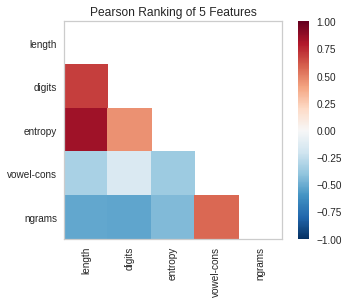

In [ ]:
visualizer = Rank2D(algorithm='pearson',features=feature_names)
visualizer.fit_transform( features )
visualizer.poof()

Rule of thumb: Multicollinearity occurs when the correlation between any of the variables is > 0.7.

From the graph above, entropy and length are multicolinear. Naturally, I should either keep one of the variables and delete the other. Or merge them into one variable but, I choose to keep the two variables temporarily.

In [ ]:
df_final.corr()

,isDGA,length,entropy,digits,vowel-cons,ngrams
isDGA,1.000000,0.565344,0.593145,0.318639,-0.499757,-0.635843
length,0.565344,1.000000,0.850826,0.693033,-0.323068,-0.520380
entropy,0.593145,0.850826,1.000000,0.453853,-0.364859,-0.440862
digits,0.318639,0.693033,0.453853,1.000000,-0.150420,-0.529840
vowel-cons,-0.499757,-0.323068,-0.364859,-0.150420,1.000000,0.576754
ngrams,-0.635843,-0.520380,-0.440862,-0.529840,0.576754,1.000000


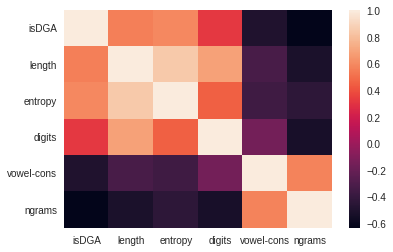

In [ ]:
sns.heatmap(df_final.corr());

Rule of thumb concerning the correlation table and heatmap: 



*   Positive values have direct correlation meaning as one variable's value increases, the other variable's value increases.
*   Negative values have inverse correlation meaning as one variable's value increases, the other variables value decreases.



### **Transforming the fresh dataset** 

The utmost reason for transforming this dataset is to make it similar to the training data. 

Rule of thumb: In machine learning, your train and test data must be similar in terms of input features.

In [ ]:
## Load data
df_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dga_classifier/dga-24000.csv')

In [ ]:
# shows the first five rows in the assignment dataset
df_1.head()

,Domain,Family
0,google.com,benign
1,facebook.com,benign
2,youtube.com,benign
3,twitter.com,benign
4,instagram.com,benign


In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Domain  24000 non-null  object
 1   Family  24000 non-null  object
dtypes: object(2)
memory usage: 375.1+ KB


finding: no missing value

In [ ]:
# installation of a library that will help to extract the suffix from the domain column
!pip install tldextract

In [ ]:
# function that will extract the suffix from the domain in the assignment dataset
import tldextract
import numpy as np
def domain_extract(Domain):
    ext = tldextract.extract(Domain)
    if (not ext.suffix):
        return np.nan
    else:
        return ext.domain

df_1['domain'] = [ domain_extract(Domain) for Domain in df_1['Domain']]
del df_1['Domain']
display(df_1)

,Family,domain
0,benign,google
1,benign,facebook
2,benign,youtube
3,benign,twitter
4,benign,instagram
...,...,...
23995,locky,fhyibfwhpahb
23996,locky,nlgusntqeqixnqyo
23997,locky,awwduqqrjxttmn
23998,locky,ccxmwif


extracted '.com, .net, .org ' from the domain names.

In [ ]:
#checking for missing columns after the extraction process
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Family  24000 non-null  object
 1   domain  23977 non-null  object
dtypes: object(2)
memory usage: 375.1+ KB


In [ ]:
df_1.isnull().sum()

Family     0
domain    23
dtype: int64

23 missing records in the domain column

In [ ]:
df_1.dropna(subset=['domain'], inplace=True)

dropped rows with missing domains

In [ ]:
df_1.isnull().sum()

Family    0
domain    0
dtype: int64

In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23977 entries, 0 to 23999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Family  23977 non-null  object
 1   domain  23977 non-null  object
dtypes: object(2)
memory usage: 562.0+ KB


all missing records have been addressed, now our data is halfway ready and similar to the training set.

In [ ]:
# Count how many entries exist for each malware family 
df_1.value_counts('Family')

Family
banjori      1000
benign       1000
tinba        1000
symmi        1000
suppobox     1000
simda        1000
shiotob      1000
shifu        1000
rovnix       1000
ranbyus      1000
ramnit       1000
qakbot       1000
qadars       1000
pykspa_v1    1000
ngioweb      1000
necro        1000
mydoom       1000
murofet      1000
locky        1000
gameover     1000
flubot       1000
emotet       1000
virut        1000
necurs        977
dtype: int64

### Performing the same transformation prformed on the training set that led to the new input features

In [ ]:
df_1['length'] = [len(x) for x in df_1['domain']] # This code will create a new column called 'length' and get the length of each domain in the dataset.

import math
from collections import Counter  # this library will be applied to the 'number of digits' code.
 
# Function to calculate the entropy of every domain in the dataset
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

# Function to calculate the vowel-consonant ratio per domain  
df_1['entropy'] = [entropy(x) for x in df_1['domain']]

def vowel_consonant_ratio (x):
    # Calculate vowel to consonant ratio
    x = x.lower()
    vowels_pattern = re.compile('([aeiou])')
    consonants_pattern = re.compile('([b-df-hj-np-tv-z])')
    vowels = re.findall(vowels_pattern, x)
    consonants = re.findall(consonants_pattern, x)
    try:
        ratio = len(vowels) / len(consonants)
    except: # catch zero devision exception 
        ratio = 0  
    return ratio

In [ ]:
# # derive features and addition of these new features as new columns to the already existing dataset
df_1['length'] = df_1.domain.str.len()
df_1['digits'] = df_1.domain.str.count('[0-9]')  # counts the number of digits in each domain.
df_1['entropy'] = df_1.domain.apply(entropy)
df_1['vowel-cons'] = df_1.domain.apply(vowel_consonant_ratio)

# check intermediate 2D pandas DataFrame
df_1.sample(n=5).head()

,Family,domain,length,entropy,digits,vowel-cons
17928,qakbot,lsakghlwzznclwljlc,18,3.191612,0,0.058824
5489,simda,tufydopogab,11,3.277613,0,0.571429
20019,shifu,vroukdd,7,2.521641,0,0.400000
18302,symmi,ddns,4,1.500000,0,0.000000
9909,ranbyus,nmavngqhqejgpiqif,17,3.454822,0,0.307692


In [ ]:
def ngrams(word, n):
    # Extract all ngrams and return a regular Python list
    # Input word: can be a simple string or a list of strings
    # Input n: Can be one integer or a list of integers 
    # if you want to extract multipe ngrams and have them all in one list
    
    l_ngrams = []
    if isinstance(word, list):
        for w in word:
            if isinstance(n, list):
                for curr_n in n:
                    ngrams = [str(w)[i:i+curr_n] for i in range(0,len(str(w))-curr_n+1)]
                    l_ngrams.extend(ngrams)
            else:
                ngrams = [w[i:i+n] for i in range(0,len(w)-n+1)]
                l_ngrams.extend(ngrams)
    else:
        if isinstance(n, list):
            for curr_n in n:
                ngrams = [word[i:i+curr_n] for i in range(0,len(word)-curr_n+1)]
                l_ngrams.extend(ngrams)
        else:
            ngrams = [word[i:i+n] for i in range(0,len(word)-n+1)]
            l_ngrams.extend(ngrams)
#     print(l_ngrams)
    return l_ngrams
def ngram_feature(domain, d, n):
    # Input is your domain string or list of domain strings
    # a dictionary object d that contains the count for most common english words
    # finally you can have either an int list or simple int defining the ngram length
    
    # Core magic: Looks up domain ngrams in english dictionary ngrams and sums up the 
    # respective english dictionary counts for the respective domain ngram
    # sum is normalized
    
    l_ngrams = ngrams(domain, n)
#     print(l_ngrams)
    count_sum=0
    for ngram in l_ngrams:
        if d[ngram]:
            count_sum+=d[ngram]
    try:
        feature = count_sum/(len(domain)-n+1)
    except:
        feature = 0
    return feature
    
def average_ngram_feature(l_ngram_feature):
    # input is a list of calls to ngram_feature(domain, d, n)
    # usually you would use various n values, like 1,2,3...
    return sum(l_ngram_feature)/len(l_ngram_feature)


l_en_ngrams = ngrams(list(top_en_words['words']), [1,2,3])
d = Counter(l_en_ngrams)

from six.moves import cPickle as pickle
with open('/content/drive/MyDrive/Colab Notebooks/dga_classifier/d_common_en_words.pickle' + '.pickle', 'wb') as f:
        pickle.dump(d, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
df_1['ngrams'] = df_1.domain.apply(lambda x: average_ngram_feature([ngram_feature(x, d, 1), 
                                                                ngram_feature(x, d, 2), 
                                                                ngram_feature(x, d, 3)]))

# check final 2D pandas DataFrame containing all final features and the target vector isDGA
df_1.sample(n=5).head()

,Family,domain,length,entropy,digits,vowel-cons,ngrams
18010,symmi,ddns,4,1.500000,0,0.000000,1299.833333
8714,gameover,1j35wkn1engnmmbu0alm13e09az,27,3.930270,9,0.384615,721.398367
1853,banjori,jhkkestnessbiophysicalohax,26,3.825252,0,0.444444,1275.483718
9751,ranbyus,emwhrgfausjhjugqc,17,3.616875,0,0.307692,804.693627
11484,virut,oylyuc,6,2.251629,0,0.500000,828.900000


In [ ]:
test_data = df_1
test_data = test_data.drop(['domain'], axis=1)
test_data.head()

,Family,length,entropy,digits,vowel-cons,ngrams
0,benign,6,1.918296,0,1.000000,1325.688889
1,benign,8,2.750000,0,1.000000,1195.261905
2,benign,7,2.521641,0,1.333333,1132.614286
3,benign,7,2.128085,0,0.400000,1731.160317
4,benign,9,2.947703,0,0.500000,1639.345899


### **Machine Learning Section** 

df_final will be the train data while, test_data will be the test data.

In [ ]:
# the train data is split into two datasets input features (independent variables) and target or dependent variable
target = df_final['isDGA']
feature_matrix = df_final.drop(['isDGA'], axis=1)
print('Final features', feature_matrix.columns)

print( feature_matrix.head())

Final features Index(['length', 'entropy', 'digits', 'vowel-cons', 'ngrams'], dtype='object')
   length   entropy  digits  vowel-cons      ngrams
0      26  4.315824       9    0.214286  535.332821
1      14  3.235926       0    0.000000  728.143162
2      14  3.182006       0    0.272727  722.200855
3      25  4.163856      10    0.250000  474.490556
4      12  3.584963       0    0.333333  944.839394


**Cross Validation** 

Splitting the train data into train data and validation (val) data.

In [ ]:
feature_matrix_train, feature_matrix_val, target_train, target_val = model_selection.train_test_split(feature_matrix, target, test_size=0.25, random_state=42)

In [ ]:
feature_matrix_train.count()

length        119998
entropy       119998
digits        119998
vowel-cons    119998
ngrams        119998
dtype: int64

In [ ]:
feature_matrix_val.count()

length        40000
entropy       40000
digits        40000
vowel-cons    40000
ngrams        40000
dtype: int64

In [ ]:
target_train.head()

103950    0
122915    0
67153     1
138831    0
118731    0
Name: isDGA, dtype: int64

**Model Training and Prediction**

First Model: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train the random tree classifier based on the train split from the train data
clf = RandomForestClassifier(max_depth=100, random_state=42) # clf means classifier
clf = clf.fit(feature_matrix_train, target_train)


**Model Accuracy Assessment with Cross Validation** 

*   We will use the trained model to predict the labels of our validation data (X_test). We will run '.predict()' method on the classifier with the validation data (X_test) and store the results in a variable called target_pred.. 

*   Then we calculate the accuracy using target_test (which are the true labels) alongside, the models predictions on the validation portion target_pred as inputs. The advantage here is to see how our model performs on new data it has not been seen during the training phase. 

*   Finally, we will print out the confusion matrix.

PS: For the classification report, Legit = 0; which means the domain was not generated by a DGA and vice versa.

Also concerning the classification report, our focus will mostly be on the accuracy score because the target variable ('isDGA') has balanced data point occurrences for each class.



To understand the confusion matrix, here's a sample diagram:

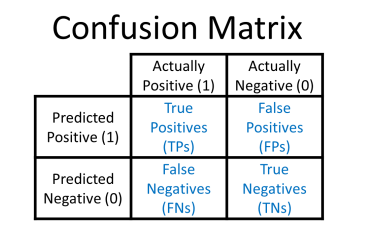

One of the major goals of machine learning is to have any algorithm predict more True Positives (TP's) and True Negatives (TN's) compared to False Positives (FP's) and False Negatives (FN's).

In [ ]:
# making prediction on the validation data portion
target_pred_1 = clf.predict(feature_matrix_val)  # predicted values
print(metrics.accuracy_score(target_val, target_pred_1))
print('Confusion Matrix\n', metrics.confusion_matrix(target_val, target_pred_1))

0.887275
Confusion Matrix
 [[17951  2216]
 [ 2293 17540]]


In [ ]:
# Classification Report
print(metrics.classification_report(target_val, target_pred_1, target_names=['legit', 'dga']))

              precision    recall  f1-score   support

       legit       0.89      0.89      0.89     20167
         dga       0.89      0.88      0.89     19833

    accuracy                           0.89     40000
   macro avg       0.89      0.89      0.89     40000
weighted avg       0.89      0.89      0.89     40000



In [ ]:
# short-cut accuracy score
clf.score(feature_matrix_val, target_val)

0.887275

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


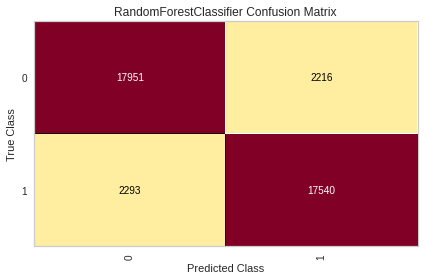

In [ ]:
from yellowbrick.classifier import ConfusionMatrix
viz = ConfusionMatrix(clf)
viz.fit(feature_matrix_train, target_train)
viz.score(feature_matrix_val, target_val)
viz.poof()

The random forest confusion matrix shows that the algorithm predicted the following:



*   True Positives: 17540
*   True Negatives: 17951
*   False Positives: 2216
*   False Negatives: 2293





**Second Model: Logistic Regression** 

In [ ]:
from sklearn.linear_model import LogisticRegression
# Train the logistic regression classifier based on the train split from the train data
clf_2 = LogisticRegression(random_state=42) # clf means classifier
clf_2 = clf_2.fit(feature_matrix_train, target_train)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
# making prediction on the validation data portion
target_pred_2 = clf_2.predict(feature_matrix_val)  # predicted values
print(metrics.accuracy_score(target_val, target_pred_2))
print('Confusion Matrix\n', metrics.confusion_matrix(target_val, target_pred_2))

0.8797
Confusion Matrix
 [[18137  2030]
 [ 2782 17051]]


In [ ]:
# Classification Report
print(metrics.classification_report(target_val, target_pred_2, target_names=['legit', 'dga']))

              precision    recall  f1-score   support

       legit       0.87      0.90      0.88     20167
         dga       0.89      0.86      0.88     19833

    accuracy                           0.88     40000
   macro avg       0.88      0.88      0.88     40000
weighted avg       0.88      0.88      0.88     40000



In [ ]:
# short-cut accuracy score
clf_2.score(feature_matrix_val, target_val)

0.8797

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


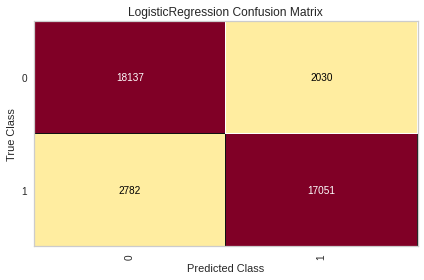

In [ ]:
from yellowbrick.classifier import ConfusionMatrix
viz_2 = ConfusionMatrix(clf_2)
viz_2.fit(feature_matrix_train, target_train)
viz_2.score(feature_matrix_val, target_val)
viz_2.poof()

The logistic regression confusion matrix shows that the algorithm predicted the following:



*   True Positives: 17051
*   True Negatives: 18137
*   False Positives: 2030
*   False Negatives: 2782


**Third Model: MLP Classifier** 

In [ ]:
from sklearn.neural_network import MLPClassifier
# Train the MLP classifier based on the train split from the train data
clf_3 = MLPClassifier(random_state=42, max_iter=300) # clf means classifier
clf_3 = clf_3.fit(feature_matrix_train, target_train)


In [ ]:
# making prediction on the validation data portion
target_pred_3 = clf_3.predict(feature_matrix_val)  # predicted values
print(metrics.accuracy_score(target_val, target_pred_3))
print('Confusion Matrix\n', metrics.confusion_matrix(target_val, target_pred_3))

0.869875
Confusion Matrix
 [[16630  3537]
 [ 1668 18165]]


In [ ]:
# Classification Report
print(metrics.classification_report(target_val, target_pred_3, target_names=['legit', 'dga']))

              precision    recall  f1-score   support

       legit       0.91      0.82      0.86     20167
         dga       0.84      0.92      0.87     19833

    accuracy                           0.87     40000
   macro avg       0.87      0.87      0.87     40000
weighted avg       0.87      0.87      0.87     40000



In [ ]:
# short-cut accuracy score
clf_3.score(feature_matrix_val, target_val)

0.869875

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


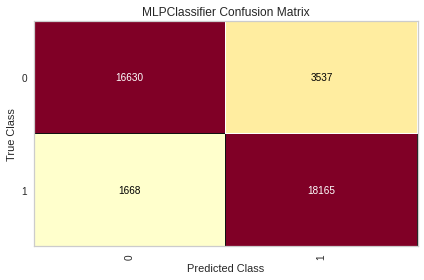

In [ ]:
from yellowbrick.classifier import ConfusionMatrix
viz_3 = ConfusionMatrix(clf_3)
viz_3.fit(feature_matrix_train, target_train)
viz_3.score(feature_matrix_val, target_val)
viz_3.poof()

The MLP Classifier confusion matrix shows that the algorithm predicted the following:



*   True Positives: 18165
*   True Negatives: 16630
*   False Positives: 3537
*   False Negatives: 1668


**Deciding on the best model using the prediction obtained from the validation data**

In [ ]:
# convert predictions from the 3 models to a dataframe
predictions = pd.DataFrame(target_pred_1, columns=['prediction1'])
predictions['prediction2']= target_pred_2
predictions['prediction3']= target_pred_3

# a function that calculates the mode
from statistics import mode
def calculate_mode(val):
  prediction1 = val[0]
  prediction2 = val[1]
  prediction3 = val[2]
  val = [prediction1, prediction2, prediction3]

  return int(mode(val))

# slice it using the pandas apply function
pred_mode = predictions[['prediction1', 'prediction2', 'prediction3']].apply(calculate_mode, axis=1)
pred_mode= pred_mode.to_numpy()

In [ ]:
predictions

,prediction1,prediction2,prediction3
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,0,0,0
...,...,...,...
39995,1,1,1
39996,1,1,1
39997,1,1,1
39998,0,1,1


In [ ]:
pred_mode

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
pred_mode = pd.DataFrame(pred_mode)

In [ ]:
predictions = predictions.join(pred_mode)
predictions.head()

,prediction1,prediction2,prediction3,0
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,0,0,0,0


In [ ]:
predictions= predictions.rename(columns= {0: 'Prediction Mode'})
predictions

,prediction1,prediction2,prediction3,Prediction Mode
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,0,0,0,0
...,...,...,...,...
39995,1,1,1,1
39996,1,1,1,1
39997,1,1,1,1
39998,0,1,1,1


Conclusion: Basically, since the 3 classifiers had almost the same accuracy score, and some of the classifiers were better at predicting the DGA generated domains and vice versa, I decided to try a boosting method. This will combine the strengths of the 3 classifiers to produce a balanced prediction. The weakness of one classifier was the strength of another. The boosting method adopted here was, finding the mode from the predictions of the 3 classifiers to create a balanced final prediction. 

To understand my conclusion better, observe the confusion matrix of each classifier.


### **Applying the bagging method to the real test data (Fresh Dataset)** 

Data Preprocessing

In [ ]:
# dropping the final column 'Family' that will make our test data totally ready for the machine learning model.
family_data = test_data['Family']
main_test = test_data.drop(['Family'], axis=1)
print('Final input variables', main_test.columns)

print( main_test.head())

Final input variables Index(['length', 'entropy', 'digits', 'vowel-cons', 'ngrams'], dtype='object')
   length   entropy  digits  vowel-cons       ngrams
0       6  1.918296       0    1.000000  1325.688889
1       8  2.750000       0    1.000000  1195.261905
2       7  2.521641       0    1.333333  1132.614286
3       7  2.128085       0    0.400000  1731.160317
4       9  2.947703       0    0.500000  1639.345899


In [ ]:
# checking for missing values
main_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23977 entries, 0 to 23999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   length      23977 non-null  int64  
 1   entropy     23977 non-null  float64
 2   digits      23977 non-null  int64  
 3   vowel-cons  23977 non-null  float64
 4   ngrams      23977 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 1.1 MB


Using Random Forest, Logistic Regressor and MLP Classifier to Predict

In [ ]:
rf_predicted = clf.predict(main_test)  #randomforest prediction
lr_predicted = clf_2.predict(main_test) #logistic regressor prediction
mlp_predicted = clf_3.predict(main_test) #mlp classifier prediction

In [ ]:
# convert predictions from the 3 models to a dataframe
test_predictions = pd.DataFrame(rf_predicted, columns=['rf_prediction'])
test_predictions['lr_prediction']= lr_predicted
test_predictions['mlp_prediction']= mlp_predicted

# a function that calculates the mode
from statistics import mode
def calculate_mode(test_val):
  rf_prediction = test_val[0]
  lr_prediction = test_val[1]
  mlp_prediction = test_val[2]
  test_val = [rf_prediction, lr_prediction, mlp_prediction]

  return int(mode(test_val))

# slice it using the pandas apply function
test_pred_mode = test_predictions[['rf_prediction', 'lr_prediction', 'mlp_prediction']].apply(calculate_mode, axis=1)
test_pred_mode= test_pred_mode.to_numpy()

In [ ]:
# to give a preview of what some of the prdictictions look like per classifier
test_predictions

,rf_prediction,lr_prediction,mlp_prediction
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
23972,1,1,1
23973,1,1,1
23974,1,1,1
23975,1,1,1


In [ ]:
 # changing the mode/ final prediction from a numpy array to a dataframe with one column
 test_pred_mode = pd.DataFrame(test_pred_mode)

In [ ]:
# joining the prediction mode dataframe to the classifiers predictions.
test_predictions = test_predictions.join(test_pred_mode)
test_predictions= test_predictions.rename(columns= {0: 'Prediction Mode'})
test_predictions

,rf_prediction,lr_prediction,mlp_prediction,Prediction Mode
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
23972,1,1,1,1
23973,1,1,1,1
23974,1,1,1,1
23975,1,1,1,1


In [ ]:
# since we have now obtained the final prediction, the family column that was initially dropped can be merged with the test data alongside the prediction column
# the goal here is to prepare our dataset for data analysis

predicted_result = main_test.join(family_data)
predicted_result = predicted_result.join(test_pred_mode)
predicted_result.head()

,length,entropy,digits,vowel-cons,ngrams,Family,0
0,6,1.918296,0,1.000000,1325.688889,benign,0.0
1,8,2.750000,0,1.000000,1195.261905,benign,0.0
2,7,2.521641,0,1.333333,1132.614286,benign,0.0
3,7,2.128085,0,0.400000,1731.160317,benign,0.0
4,9,2.947703,0,0.500000,1639.345899,benign,0.0


In [ ]:
# renaming the prediction column
predicted_result= predicted_result.rename(columns= {0: 'isDGA'})
predicted_result.head()

,length,entropy,digits,vowel-cons,ngrams,Family,isDGA
0,6,1.918296,0,1.000000,1325.688889,benign,0.0
1,8,2.750000,0,1.000000,1195.261905,benign,0.0
2,7,2.521641,0,1.333333,1132.614286,benign,0.0
3,7,2.128085,0,0.400000,1731.160317,benign,0.0
4,9,2.947703,0,0.500000,1639.345899,benign,0.0


In [ ]:
# checking for empty values
predicted_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23977 entries, 0 to 23999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   length      23977 non-null  int64  
 1   entropy     23977 non-null  float64
 2   digits      23977 non-null  int64  
 3   vowel-cons  23977 non-null  float64
 4   ngrams      23977 non-null  float64
 5   Family      23977 non-null  object 
 6   isDGA       23954 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 2.0+ MB


In [ ]:
# dropping empty records in the dataset
predicted_result.dropna(subset=['length','entropy','digits','vowel-cons','ngrams','Family','isDGA'], inplace=True)

In [ ]:
predicted_result.isnull().sum()

length        0
entropy       0
digits        0
vowel-cons    0
ngrams        0
Family        0
isDGA         0
dtype: int64

In [ ]:
predicted_result.head()

,length,entropy,digits,vowel-cons,ngrams,Family,isDGA
0,6,1.918296,0,1.000000,1325.688889,benign,0.0
1,8,2.750000,0,1.000000,1195.261905,benign,0.0
2,7,2.521641,0,1.333333,1132.614286,benign,0.0
3,7,2.128085,0,0.400000,1731.160317,benign,0.0
4,9,2.947703,0,0.500000,1639.345899,benign,0.0


In [ ]:
predicted_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23954 entries, 0 to 23976
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   length      23954 non-null  int64  
 1   entropy     23954 non-null  float64
 2   digits      23954 non-null  int64  
 3   vowel-cons  23954 non-null  float64
 4   ngrams      23954 non-null  float64
 5   Family      23954 non-null  object 
 6   isDGA       23954 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 1.5+ MB


In [ ]:
# converting out predicted values from float datatype to int datatype
predicted_result['isDGA'] = predicted_result['isDGA'].astype(int) 
predicted_result.head()

,length,entropy,digits,vowel-cons,ngrams,Family,isDGA
0,6,1.918296,0,1.000000,1325.688889,benign,0
1,8,2.750000,0,1.000000,1195.261905,benign,0
2,7,2.521641,0,1.333333,1132.614286,benign,0
3,7,2.128085,0,0.400000,1731.160317,benign,0
4,9,2.947703,0,0.500000,1639.345899,benign,0


Finally, our data is ready for analysis based on the predicted results.

### **Exploratory Data Analysis of Predicted Values Results and Insights** 

The purose of Exploratory Data Analysis is to identify the features common to most importantly DGA generated domains. This will reveal the pattern the classifiers used in identifiying DGA generated domains.

In addition, the malware family's with numerous DGA generated domains should be something to be identified for knowledge and research purposes. Finally, I will like to understand the relationship between each independent variable and the target variable ('isDGA').

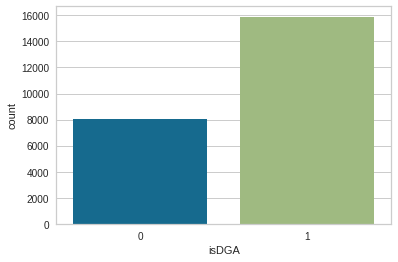

In [ ]:
sns.countplot(x = 'isDGA', data = predicted_result);

The results from the prediction show that the classifiers identified a large amount of domains in the dataset were generated by DGA's.

1 represents domains generated by DGA's.

0 represents domains that are not generated by DGA's.

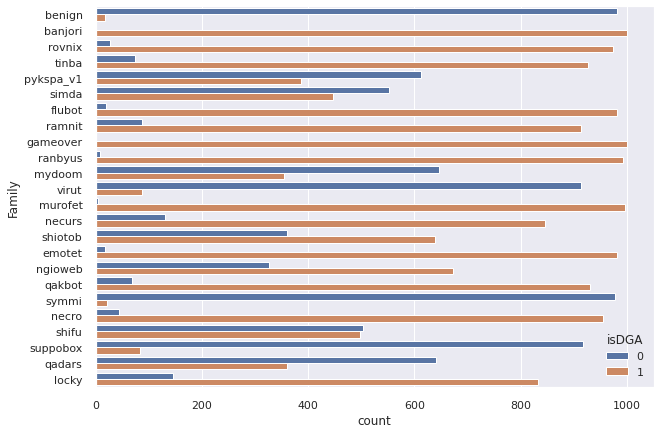

In [ ]:
sns.countplot(y = 'Family', data = predicted_result, hue='isDGA')
sns.set(rc = {'figure.figsize':(10,7)})

Our focus is on all the orange bars, which represents malware families with with high numbers of DGA generated domains.

Insight: banjori, rovnix, tinba, flubot, ramnit, gameover,ranbyus, murofet, necurs, emotet, necro and locky are malware families that have domains that are DGA generated.

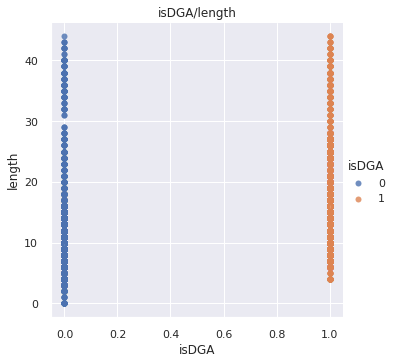

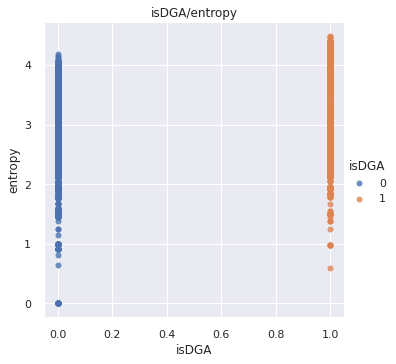

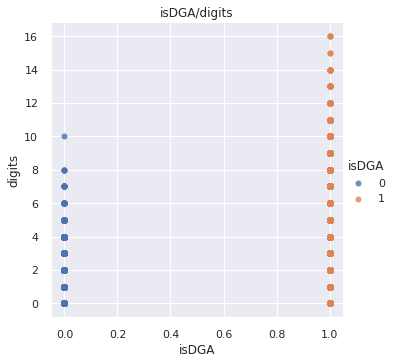

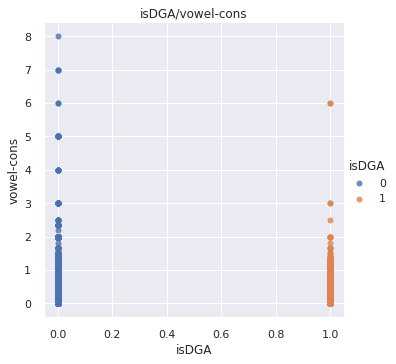

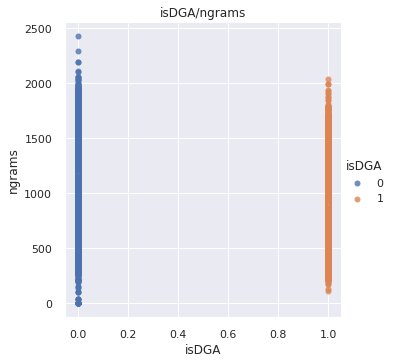

In [ ]:
for col in (predicted_result.iloc[:,:-2].columns.values):
    sns.lmplot(x='isDGA',y=col,data=predicted_result, hue= 'isDGA')
    plt.title(f'isDGA/{col}');
    plt.ylabel(col);
    plt.show();
    plt.tight_layout();
    plt.close() 
    print('   ')

Remember, our focus are on the orange dots i.e. 'isDGA' = 1

**isDGA vs Length:** prediction results show that domains generated by DGA's tend to start from 4 letters and above.

**isDGA vs Entropy:** prediction results show that domains generated by DGA's have a higher entropy level compared to domains that are not generated by DGA's.

**isDGA vs Digits:** prediction results show that domains generated by DGA's have more numbers in the domain compared to domains that are not generated by DGA's.

**isDGA vs vowel-cons:** prediction results show that domains generated by DGA's have smaller vowel to cosonant ratio with a few outliers compared to domains that are not generated by DGA's.

**isDGA vs ngrams:** prediction results show that domains generated by DGA's have smaller ngram weights/values compared to domains that are not generated by DGA's.